In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from torchinfo import summary

In [46]:
# 保证试验结果的稳定性
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 配置Cuda参数
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

batch_size = 32
num_epochs = 2

In [47]:
# 构建Dataset
mnist_train_dataset = datasets.MNIST(root=r'./data',
                                     transform=transforms.ToTensor(),
                                     train=True,
                                     download=True)

mnist_test_dataset = datasets.MNIST(root=r'./data',
                                    transform=transforms.ToTensor(),
                                    train=False,
                                    download=True)

# 构建Dataloader
mnist_train_loader = DataLoader(
    dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True)

mnist_test_loader = DataLoader(
    dataset=mnist_test_dataset, batch_size=batch_size, shuffle=True)


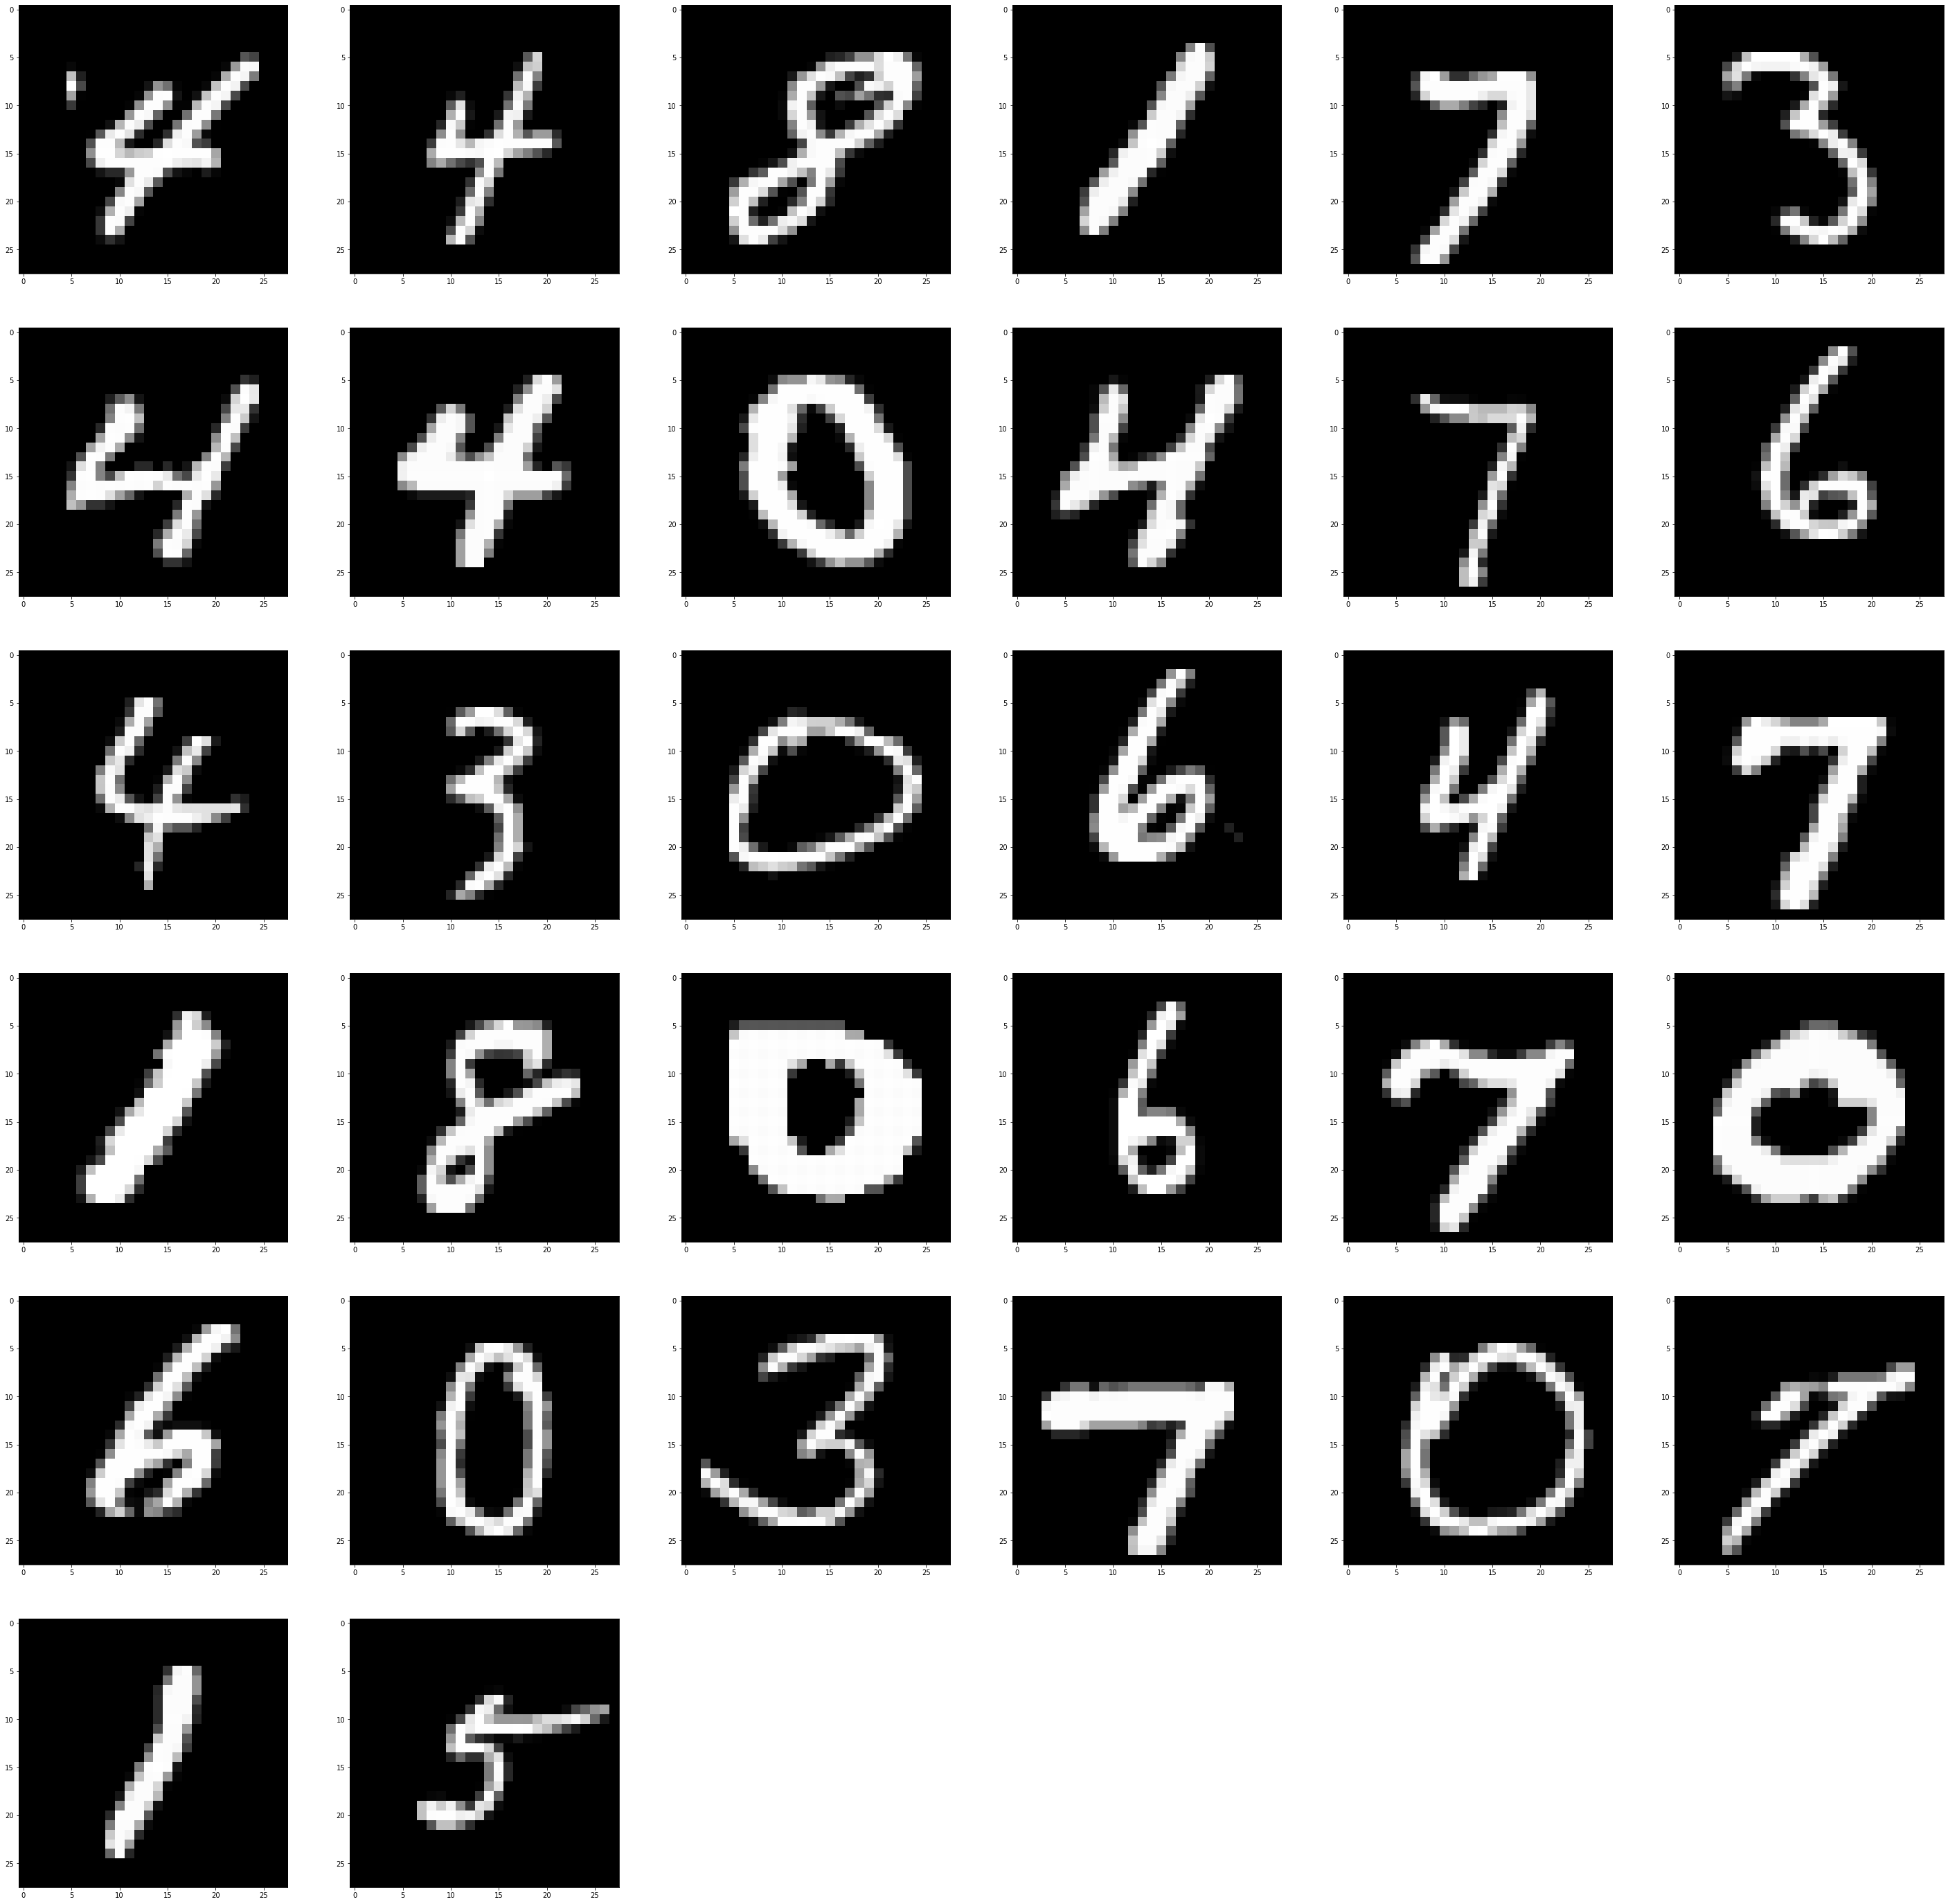

In [48]:
# 图片查看
def plot_image(image,batch_size=32):
    x_batch,y_batch = image[0],image[1]
    f = plt.figure(figsize=(50,50))
    # mean = 0.1307
    # std = 0.3081
    # image = ((image * mean) + std)
    # plt.imshow(image, cmap='gray')
    for i in range(batch_size):
        image_tx = x_batch.numpy()[i]
        # image_ty = y_batch.numpy()[i]
        np.math.sqrt(batch_size)
        # Debug, plot figure
        sub_size = int(np.math.sqrt(32))+1
        f.add_subplot(sub_size,sub_size, i + 1)
        # plt.subplot_mosaic
        plt.imshow(image_tx[0], cmap='gray')
    plt.show()

sample_image_batch = next(iter(mnist_train_loader))
plot_image(sample_image_batch)

In [49]:
# 构建网络
class MnistClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=0.25)
        # self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x= self.max_pool2d(x)
        x = self.dropout(x)
        x = x.view(-1, 9216)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x= self.log_softmax(x)
        return x

In [50]:
def fit_train(model,data_loader):
    model.train()
    running_loss = 0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output ,target ,reduction='sum').item()
        preds = output.data.max(1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        loss.backward()
        optimizer.step()
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print(f"Train loss is {loss:{5}.{2}} and Train accuracy is {accuracy:{10}.{4}} %")
    return loss, accuracy

In [51]:
def fit_eval(model,data_loader):
    model.eval()
    running_loss = 0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output ,target ,reduction='sum').item()
        preds = output.data.max(1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print(f"Eval loss is {loss:{5}.{2}} and Eval accuracy is {accuracy:{10}.{4}} %")
    return loss, accuracy

In [52]:
model = MnistClassificationNet()
if is_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [53]:
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, num_epochs):
    epoch_loss, epoch_accuracy = fit_train(model, mnist_train_loader)
    val_epoch_loss, val_epoch_accuracy = fit_eval(model, mnist_test_loader)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Train loss is  0.53 and Train accuracy is      84.64 %
Eval loss is  0.19 and Eval accuracy is       94.1 %


In [54]:
torch.save(model.state_dict(), "./checkpoints/model_pth/mnist_sd.pt")

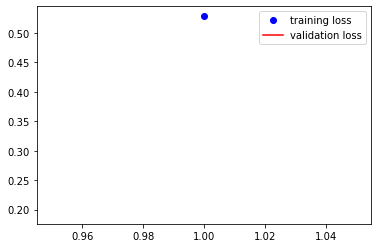

In [55]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()
plt.show()

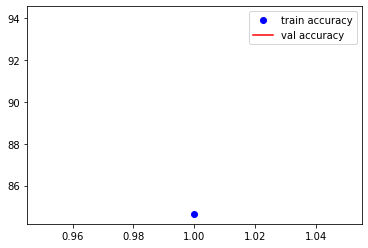

In [56]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()
plt.show()

In [ ]:
# Backup Code
def fit(epoch,model,data_loader,phases="training",volatile=False):
    if phases == "training":
        model.train()
    if phases == "validation":
        model.eval()
        volatile = True
    running_loss = 0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        # data, target = Variable(data, volatile=volatile), Variable(target)
        # data, target = Variable(data, volatile=volatile), Variable(target)
        if phases == "training":
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output ,target ,reduction='sum').item()
        preds = output.data.max(1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phases == "training":
            loss.backward()
            optimizer.step()
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    print(f"{phases} loss is {loss:{5}.{2}} and {phases} accuracy is {accuracy:{10}.{4}} %")
    return loss, accuracy


train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 2):
    epoch_loss, epoch_accuracy = fit_train(epoch, model, mnist_train_loader)
    val_epoch_loss, val_epoch_accuracy = fit_eval(
        epoch, model, mnist_test_loader)
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)